#  Podstawy Aproksymacji (część II): Deep Learning


##  Projekt: Rozpoznawanie ras psów z wykorzystaniem biblioteki Keras.

### Temat został opracowany przez:
### Michał Foryt - nr indeksu: 84172, adres e-mail: mf84172@student.sgh.waw.pl
### Szczepan Gabiec - nr indeksu: 101697, adres e-mail: sg101697@student.sgh.waw.pl
### Paweł Wróblewski - nr indeksu: 78793, adres e-mail: pw78793@student.sgh.waw.pl

<img src="meme2.jpg" style="width: 400px;">

## Wprowadzenie

Celem projektu jest stworzenie algorytmu służącego do rozpoznawaniu ras psów porzy wykorzystaniu biblioteki Keras, w oparciu o TensorFlow. Zbiór z którego korzystaliśmy pochodzi z jednego z konkursów zorganizowanych przez portal Kaggle i znajduje się pod tym linkiem: https://www.kaggle.com/c/dog-breed-identification. Z uwagi na jego rozmiar (~750MB) nie bedzie on dołączony bezpośrednio do kodu.  

W skład zbioru wchodzi około 10 tysięcy zdjęć, a wśród nich można wyróźnić 120 klas (ras psów). Pracując na tych danych, będziemy mogli stworzyć algorytm bazujący na głębokim uczeniu sieci neuronowych. W dużym uproszczeniu, zadaniem tego typu algorytmu jest rozpoznawanie obrazów podobnie, jak robi to umysł ludzki - "oglądając" ogromną pulę zdjęć z czasem rozpoznaje charakterystyczne cechy dla danego obiektu, przykładowo że rottweilera można poznać po tym, że jest duży i ma krótką, ciemną sierść, a york ma krótkie łapy i jest mocno owłosiony. Innymi słowy, algorytm najpierw zbiera dużą ilość danych, a następnie pozwala komputerowi zapoznać się z każdym z nich. Opierając się na dużych bazach danych i zauważając pojawiające się wzorce, komputery mogą rozpoznać obrazy i sformułować odpowiednie tagi i kategorie.



## 1. Konwolucyjne Sieci Neuronowe 
Konwolucyjne Sieci Neuronowe (ang. <i>CNN, Convolutional neural networks</i>, tłumaczone także jako <i>Splotowe Sieci Neuronowe</i>) w sprytny sposób redukują liczbę przyjmowanych parametrów. Zamiast działać na sieci, w której neurony są połączone każdy z każdym, podejście jakie prezentują CNN wykorzystują wielokrotnie te same parametry. Kluczem do sukcesu konwolucyjnych sieci jest fakt, że wychodza one z założenia, że wystarczy lokalne zrozumienie obrazu. Innymi słowy, algorytm skupia się na tym, by  stopniowo filtrować różne części danych uczących i wyostrzać ważne cechy w procesie dyskryminacji wykorzystanym do rozpoznawania lub klasyfikacji wzorców. W praktyce zaletą takiego podejścia jest posiadanie mniejszej liczby parametrów, co przekłada się na znaczne zmniejszenie czasu potrzebnego do wytrenowania modelu.

Rozważmy obraz o wymiarze 256 × 256 pikseli. Zamiast przetwarzać cały obraz naraz, CNN może skutecznie skanować go po kawałku - powiedzmy, patrząc na fragment o wymiarach 5 × 5. Taka ramka o wymiarach 5 × 5px przesuwa się wzdłuż obrazu (zwykle od lewej do prawej i od góry do dołu), jak pokazano na poniższym rysunku. 

<img src="cnn_concept.jpeg" style="width: 350px;">

Tempo przesuwania się takiej ramki nazywamy "długością kroku". Na przykład długość kroku 2 oznacza, że okno 5 × 5 przesuwa się o 2 piksele na raz, aż obejmie cały obraz. Taka ramka 5 x 5 pikseli przekłada się na macierz wag o wymiarze 5 x 5. 

Tego typu operacja ma miejsce w warstwie konwolucyjnej sieci neuronowej. Typowa CNN posiada wiele tego typu warste. Każda z nich zazwyczaj generuje wiele różnych splotów (ang. <i>convolutions</i>). Co za tym idzie, macierz wagowa takiego tensora (czyli obiektu matematycznego będącego uogólnieniem pojęcia wektora) ma wymiary 5 × 5 x n, gdzie n liczbą konwolucji (splotów).

Przykładowo, załóżmy że przepuszczamy rozważany obraz przez pojedynczą warstwę splotu jako macierz wagowa 5 x 5 x 64 z ramką 5 x 5. Co za ty idzie, taki model posiada 5 x 5 x64 = 1600 parametrów, podczas gdy pełna sieć dla obrazu 256 x 256px wymagałaby zastosowania 65 536 parametrów.

## 2. Przetworzenie zbioru danych
Jak już wspomnielismy na początku, wykorzystamy zbiór danych dotyczący rozpoznawania ras psów, który wstępnie został już podzielony na zbiór treningowy i testowy. Nazwa każdego z obrazów jest też jednocześnie jego unikalnym id. Cały zestaw danych zawiera zdjęcia 120 ras, jednak dla urposzczenia modelu przyjmiemy założenie, że ograniczamy się jedynie do rozpoznawania 8 najpopularniejszych.

Dla porządku, wszystkie niezbędne importy zastosujemy poniżej. Dzięki temu uzyskamy większa czytelność oraz podcas tworzenia naszej funkcjonalności będziemy mieli pewność, że wszystkie niezbędne paczki zostały już ściągnięte.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
import matplotlib.pyplot as plt
from shutil import copyfile
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import cv2
import pandas as pd

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

Czytamy dane z pliku labels, które mapują id zdjęcia z jego opisem. na zbiorze treningowym. 

In [3]:
labels = pd.read_csv('labels.csv')
labels_dict = {i:j for i,j in zip(labels['id'],labels['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir('train')]

Tworzymy nowe katalogi, które zawierają zbiory zdjęć - treningowy i testowy. 

In [4]:
if not os.path.exists('training_images'):
        os.makedirs('training_images')

if not os.path.exists('validation_images'):
    os.makedirs('validation_images')

In [5]:
print(classes)

{'giant_schnauzer', 'rhodesian_ridgeback', 'american_staffordshire_terrier', 'bedlington_terrier', 'dingo', 'ibizan_hound', 'flat-coated_retriever', 'labrador_retriever', 'airedale', 'french_bulldog', 'norfolk_terrier', 'weimaraner', 'pug', 'boston_bull', 'vizsla', 'kerry_blue_terrier', 'yorkshire_terrier', 'english_setter', 'maltese_dog', 'staffordshire_bullterrier', 'irish_setter', 'schipperke', 'pembroke', 'old_english_sheepdog', 'standard_poodle', 'clumber', 'redbone', 'african_hunting_dog', 'boxer', 'toy_poodle', 'norwegian_elkhound', 'komondor', 'irish_wolfhound', 'basset', 'saint_bernard', 'otterhound', 'irish_water_spaniel', 'cardigan', 'wire-haired_fox_terrier', 'border_terrier', 'sealyham_terrier', 'newfoundland', 'groenendael', 'lhasa', 'walker_hound', 'siberian_husky', 'kelpie', 'tibetan_mastiff', 'english_springer', 'rottweiler', 'toy_terrier', 'bull_mastiff', 'tibetan_terrier', 'sussex_spaniel', 'black-and-tan_coonhound', 'cairn', 'briard', 'scotch_terrier', 'golden_retri

Otwieramy folder z danymi treningowymi. Dla każdego z nich przygotowujemy katalogi, do których następnie będziemy zapisywać zdjęcia ras w osobne podkatalogi.

In [6]:
os.chdir('training_images')
for curClass in classes:    
    if not os.path.exists(curClass):
        os.makedirs(curClass)

 To samo robimy dla zbioru testowego. 

In [7]:
os.chdir('../validation_images')
for curClass in classes:    
    if not os.path.exists(curClass):
        os.makedirs(curClass)

Wracamy do głównego folderu. Po przygotowaniu odpowiednich katalogów możemy je wypełnić. Mamy około 20.5 tysięcy zdjęć, dzielimy je w proporcjach około 40:60 między zbiór treningowy i testowy - pierwsze 8 tysięcy zdjęć kopiujemy do odpowiednich katalogów w części uczącej, a pozostałe zdjęcia do przypisanych folderów w walidującej. 

In [8]:
os.chdir('..')
count = 0 
destination_directory = 'training_images/'
for item in images:
    if count >7999:
        destination_directory = 'validation_images/'
    filekey = os.path.splitext(item)[0]
    target_file = destination_directory+labels_dict[filekey]+'/'+item
    if not os.path.exists(target_file):
        copyfile('train/'+item, target_file)
    print(labels_dict[filekey])
    count +=1

chow
french_bulldog
redbone
chesapeake_bay_retriever
scottish_deerhound
redbone
basset
lakeland_terrier
shetland_sheepdog
cardigan
bluetick
tibetan_terrier
mexican_hairless
bedlington_terrier
groenendael
italian_greyhound
golden_retriever
italian_greyhound
komondor
lhasa
borzoi
sealyham_terrier
whippet
african_hunting_dog
samoyed
miniature_pinscher
pekinese
german_short-haired_pointer
afghan_hound
kuvasz
eskimo_dog
rottweiler
basenji
african_hunting_dog
airedale
australian_terrier
maltese_dog
great_pyrenees
greater_swiss_mountain_dog
toy_terrier
pug
bluetick
samoyed
italian_greyhound
samoyed
shih-tzu
miniature_pinscher
bouvier_des_flandres
afghan_hound
soft-coated_wheaten_terrier
newfoundland
wire-haired_fox_terrier
scotch_terrier
shih-tzu
lakeland_terrier
basenji
rottweiler
shih-tzu
chow
briard
basenji
whippet
japanese_spaniel
kuvasz
clumber
walker_hound
bernese_mountain_dog
bernese_mountain_dog
bernese_mountain_dog
irish_wolfhound
keeshond
kerry_blue_terrier
basenji
irish_water_spani

weimaraner
norfolk_terrier
basset
japanese_spaniel
appenzeller
saluki
pomeranian
norfolk_terrier
kelpie
pomeranian
miniature_schnauzer
japanese_spaniel
german_shepherd
brittany_spaniel
brabancon_griffon
siberian_husky
bull_mastiff
basenji
norwich_terrier
whippet
chow
ibizan_hound
papillon
sealyham_terrier
siberian_husky
scotch_terrier
maltese_dog
dingo
welsh_springer_spaniel
bedlington_terrier
otterhound
entlebucher
papillon
norfolk_terrier
pomeranian
scotch_terrier
miniature_schnauzer
bloodhound
airedale
french_bulldog
bedlington_terrier
pomeranian
scottish_deerhound
siberian_husky
brabancon_griffon
vizsla
blenheim_spaniel
clumber
welsh_springer_spaniel
scottish_deerhound
lhasa
toy_poodle
afghan_hound
bernese_mountain_dog
labrador_retriever
german_short-haired_pointer
komondor
brittany_spaniel
great_pyrenees
pekinese
cardigan
toy_terrier
mexican_hairless
doberman
toy_poodle
tibetan_terrier
pembroke
beagle
west_highland_white_terrier
yorkshire_terrier
irish_water_spaniel
entlebucher
mi

west_highland_white_terrier
kelpie
malamute
dingo
kerry_blue_terrier
shetland_sheepdog
toy_poodle
bedlington_terrier
standard_poodle
beagle
appenzeller
dandie_dinmont
great_pyrenees
dhole
bouvier_des_flandres
pomeranian
norwegian_elkhound
bloodhound
groenendael
shetland_sheepdog
saint_bernard
giant_schnauzer
borzoi
tibetan_mastiff
golden_retriever
german_shepherd
labrador_retriever
german_shepherd
border_collie
lakeland_terrier
briard
bloodhound
bedlington_terrier
boston_bull
cocker_spaniel
samoyed
rhodesian_ridgeback
entlebucher
saluki
australian_terrier
german_short-haired_pointer
bouvier_des_flandres
rhodesian_ridgeback
bouvier_des_flandres
bull_mastiff
french_bulldog
border_collie
affenpinscher
pug
sussex_spaniel
silky_terrier
borzoi
irish_setter
eskimo_dog
newfoundland
schipperke
german_short-haired_pointer
italian_greyhound
wire-haired_fox_terrier
papillon
miniature_pinscher
maltese_dog
appenzeller
tibetan_terrier
scottish_deerhound
kerry_blue_terrier
pembroke
bedlington_terrier


saluki
miniature_schnauzer
norfolk_terrier
bedlington_terrier
norwegian_elkhound
irish_terrier
lakeland_terrier
shih-tzu
dandie_dinmont
maltese_dog
german_short-haired_pointer
pug
bernese_mountain_dog
bernese_mountain_dog
doberman
siberian_husky
english_setter
english_foxhound
bedlington_terrier
maltese_dog
lhasa
redbone
golden_retriever
pembroke
kerry_blue_terrier
briard
irish_water_spaniel
toy_poodle
malamute
pomeranian
labrador_retriever
malinois
brabancon_griffon
norfolk_terrier
chow
old_english_sheepdog
irish_water_spaniel
pekinese
keeshond
japanese_spaniel
flat-coated_retriever
australian_terrier
weimaraner
cairn
maltese_dog
american_staffordshire_terrier
briard
beagle
norwegian_elkhound
entlebucher
appenzeller
japanese_spaniel
soft-coated_wheaten_terrier
entlebucher
leonberg
giant_schnauzer
lhasa
welsh_springer_spaniel
sealyham_terrier
bouvier_des_flandres
wire-haired_fox_terrier
american_staffordshire_terrier
kerry_blue_terrier
appenzeller
weimaraner
tibetan_terrier
airedale
bo

great_dane
newfoundland
chesapeake_bay_retriever
papillon
ibizan_hound
boxer
groenendael
redbone
sussex_spaniel
bouvier_des_flandres
italian_greyhound
whippet
rhodesian_ridgeback
standard_schnauzer
giant_schnauzer
german_shepherd
cairn
border_terrier
appenzeller
irish_terrier
malamute
walker_hound
appenzeller
miniature_poodle
lhasa
japanese_spaniel
great_pyrenees
rhodesian_ridgeback
australian_terrier
affenpinscher
italian_greyhound
komondor
brabancon_griffon
collie
malamute
lhasa
saint_bernard
tibetan_terrier
collie
bull_mastiff
west_highland_white_terrier
clumber
toy_poodle
yorkshire_terrier
english_setter
bedlington_terrier
briard
rottweiler
golden_retriever
sussex_spaniel
basset
otterhound
basset
samoyed
rhodesian_ridgeback
komondor
siberian_husky
flat-coated_retriever
boston_bull
great_pyrenees
tibetan_terrier
borzoi
bouvier_des_flandres
siberian_husky
english_foxhound
kuvasz
west_highland_white_terrier
pekinese
japanese_spaniel
yorkshire_terrier
malamute
collie
old_english_sheepd

pomeranian
german_short-haired_pointer
bloodhound
bull_mastiff
irish_water_spaniel
irish_setter
bull_mastiff
english_foxhound
pekinese
gordon_setter
weimaraner
irish_terrier
west_highland_white_terrier
great_dane
bull_mastiff
tibetan_terrier
soft-coated_wheaten_terrier
redbone
american_staffordshire_terrier
norfolk_terrier
irish_terrier
ibizan_hound
basenji
toy_terrier
afghan_hound
bull_mastiff
australian_terrier
cairn


## 3. Image Augmentation - Przekształcenie obrazów
Image augmentation to technika polegająca na przekształcaniu oryginalnego obrazu tak, by uzyskać nowe dane testowe. Przykładowo dzieje się to poprzez dodanie szumu albo lustrzane odbicie. Dzięki temu możemy uzyskć więcej zdjęć testowych. W Pythonie, służy do tego klasa ImageDataGenerator, która ustawia parametry takie jak rotacja obrazu przybliżenie czy znieształcenie. Wykorzystamy ją do wygenerowania setek wariacji jednego ze zdjęć.   

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('training_images/afghan_hound/0d5a88f0ab2db8d34b533c69768135e8.jpg') 
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0

if not os.path.exists('preview'):
        os.makedirs('preview')

for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='dog_breed', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # W przeciwnym pzypadku generator będzie działać w nieskonczoność

## 4. Implementacja sieci neuronowej
Na początku dokonujemy przekształcenia zbioru testowego. Przeskalowanie to wartość, o którą pomnożymy dane przed jakimkolwiek innym przetwarzaniem. Nasze oryginalne obrazy składają się ze współczynników RGB w zakresie 0–255, ale takie wartości byłyby zbyt wysokie, aby nasz model mógł je przetworzyć (biorąc pod uwagę typowy learning rate), więc zamiast tego celujemy wartości z zakresu od 0 do 1, skalując je z dokładnością 1/255. Z kolei parametr shear_range pozwala przekształcić obraz pod pewnym kątem (bardziej obrazowo - zamiast obrazu w postaci kwadratu otrzymujemy równoległobok), natomiast zoom_range odpowiada za stopień przybliżenia bądź oddalenia obrazka, a horizontal_flip tworzy jego odbicie. Wszystkie te zabiegi mają sprawić, że zbiór treningowy bedzie nieco różnić się od zbioru testowego, by uniknąć nadmiernego dopasowania do danych.


In [10]:
#Train datagen tworzy generator danych testowych
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

#Test_datagen tworzy generator danych walidacyjnych. W tym przypadku jedynie normalizujemy rozmiar zdjęć. 
test_datagen = ImageDataGenerator(rescale=1./255)

Mając stworzone odpowiednie generatory można przystąpić do właśniwego wygenerowania odpowiednich zdjęć. Przekazując parametr class_mode='categorical' unikamy manualanej konwersji etykiet na odpowiednie wektory - generator zrobi to za nas. 

In [11]:
training_set = train_datagen.flow_from_directory(
        'training_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

Found 8000 images belonging to 120 classes.
Found 2222 images belonging to 120 classes.


Majac już przygotowane dane treningowe i testowe możemy przystąpić do tworzenia modelu sieci konwolucyjnej. Wykorzystamy model sekwencyjny (Sequential), który jest odpowiedni dla zwykłego stosu warstw, gdzie każda warstwa ma dokładnie jeden tensor wejściowy i jeden tensor wyjściowy. Tego typu model nie sprawdziłby się w przypadku, gdy przykładwo model lub którakolwiek z warstw ma wiele wejść lub wyjść.

Tworzymy pierwszą warstwę, którą dodamy do sieci. Ponieważ dotyczy ona obiektów dwuwymiarowych, wykorzystamy klasę *Conv2D*. Jako parametry w konstruktorze przekazujemy następujace argumenty:   
- **filters** - liczba całkowita, określająca wymiar otrzymany na wyjściu (tj. liczba filtrów wyjściowych w konwolucji).
- **kernel_size** - lista / krotka składająca się z 2 liczb całkowiych, okreslająca rozmiar okna 2D. 
- **input_shape** - ponieważ jest to pierwsza warstwa należy podać wektor wejsćiowy. W tym przpyadku będzie to okno 128x128 px, a przez 3 oznaczamy listę 3 elementów - nasycenie odpowiednich barw w notacji RGB. 
- **activation** - oznacza funckję aktywacji w danej warstwie. W tym przypadku jest to rectified linear unit (ReLU), choć możliwe jest też ustawienie np. funkcji sigmoidalnej lub wykładniczej.  

Warstwa łącząca (pooling layer) służy do progresywnej redukcji rozmiaru przestrzennego do zredukowania ilości cech i złożoności obliczeniowej sieci. Najczęściej w sieciach konwolucyjnych stosujemy warstwę MaxPool która przesuwa filtry (tu - 2x2) przez całą macierz wyciągając największą wartość z okna filtra i zapisuje ją do następnej mapy.

Najważniejszy powód stosowania warstw łączących jest uchronienie modelu przed przeuczeniem. Czasami stosujemy też warstwę opuszczającą, która zastępuje warstwę łączącą. Należy być ostrożnym przy stosowaniu warstwy łączącej, szczególnie w zadaniach wizyjnych, gdyż może to spowodować utratę lokalnej wrażliwości modelu mimo zmniejszenia rozmiaru modelu.

In [12]:
clf = Sequential()
clf.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))   
clf.add(MaxPooling2D(pool_size=(2,2)))  
#clf.add(Dropout(0.5))

clf.add(Conv2D(32,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
#clf.add(Dropout(0.25))

clf.add(Conv2D(64, (3, 3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))
#clf.add(Dropout(0.10))
#Flattening
clf.add(Flatten())
        
#Adding An ANN
#lets take 128 hidden nodes in hidden layer
#clf.add(Dense(units=128,activation='relu'))
clf.add(Dense(units=64, activation='relu'))
clf.add(Dropout(0.5))
clf.add(Dense(units=120,activation='softmax'))
#stochastic gradient descent -Adam -optimizer
#loss func categorical cross entropy
#metrics = accuracy
clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

W tym modelu zastosowaliśmy metodę wczesnego zakończenia (early stopping). Polega na tym, by zakończyć uczenie, gdy strata na zbiorze testowym nie rośnie. Czyli trenując dalej sieć nie poprawiamy mocy modelu na zbiorze testowym. 
W Tensorflow mamy do dyspozycji funkcję EarlyStopping, która monitoruje stratę na zbiorze testowym po zakończeniu każdej epoki. Jeśli strata nie maleje, wówczas trening sieci zostaje zatrzymany. Należy zdefiniować 3 podstawowe parametry ustawiając early stopping:

- **monitor** – definiujemy, co chcemy monitorować na podstawie czego zatrzymamy proces uczenia,
- **patience** – tym parametrem definiujemy liczbę epok po ilu zatrzyma się nasz model jeśli nie zaobserwujemy zmniejszania się funkcji straty,
- **verbose** – w jaki sposób będzie wyświetlana informacja o early stoping.

W naszym modelu skonfigurujemy tylko parametr patience, resztę pozostawiamy domyślnie. 

In [13]:
early_stopping_monitor=EarlyStopping(patience=6)

Uruchamiamy metodę *fit_generator*. *keras.fit()* oraz *keras.fit_generator()* stanowią dwie odrębne biblioteki do głębokiego uczenia maszynowego, które mogą być wykorzystane do trenowania zarówno modeli machine learningowych jak i deep learningowych. Obie funkcje wykonują to samo, natomiast kluczem pozostaje to, w jaki sposób to realizują.
*fit* jest używany, gdy cały zestaw danych treningowych może zmieścić się w pamięci i nie stosuje się żadnego przekształcania danych (data augumentation).
*fit_generator* wykorzystuje się, gdy pracujemy na dużym zbiorze danych, który nie mieści się w pamięci tymczasowej bądź też wykorzystujemy metodę data augumentation.

Wykorzystana przez nas metoda przyjmuje następujące parametry:
- training_set - zbiór treningowy
- steps_per_epoch - to liczba iteracji wsadowych (*batch iterations*), zanim epoka zostanie uznana za zakończoną. Jeśli mamy zestaw treningowy o ustalonym rozmiarze, można go zignorować, ale może być przydatny, jeśli mamy duży zestaw danych lub generujemy losowe rozszerzenia danych.
- batch_size - wielkość próbki danych (batch). Określa liczbę próbek w każdej mini partii.
- validation_steps - parametr podobny do steps_per_epoch, ale ma zastosowanie w zestawie danych walidacyjnych zamiast w danych szkoleniowych.

In [14]:
hist=clf.fit_generator(
        training_set,
        steps_per_epoch=400,
        epochs=50,
        validation_data=test_set,
        validation_steps=2222,
        callbacks=[early_stopping_monitor])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
400/400 [==============================] - 749s 2s/step - loss: 4.7880 - accuracy: 0.0100 - val_loss: 4.7852 - val_accuracy: 0.0095
Epoch 2/50
400/400 [==============================] - 739s 2s/step - loss: 4.7837 - accuracy: 0.0117 - val_loss: 4.7837 - val_accuracy: 0.0090
Epoch 3/50
400/400 [==============================] - 667s 2s/step - loss: 4.7816 - accuracy: 0.0129 - val_loss: 4.7827 - val_accuracy: 0.0132
Epoch 4/50
400/400 [==============================] - 708s 2s/step - loss: 4.7805 - accuracy: 0.0117 - val_loss: 4.7826 - val_accuracy: 0.0130
Epoch 5/50
400/400 [==============================] - 739s 2s/step - loss: 4.7791 - accuracy: 0.0115 - val_loss: 4.7824 - val_accuracy: 0.0130
Epoch 6/50
400/400 [==============================] - 750s 2s/step - loss: 4.7781 - accuracy: 0.0116 - val_loss: 4.7825 - val_accuracy: 0.0132
Epoch 7/50
400/400 [==============================] - 801s 2s/step

Mając wytrenowany model możemy go przetestować. W tym celu najpierw normalizujemy rozmiar zdjęć, a następnie wykorzystując metodę *predict* stosujemy nasz model do klasyfikacji danych testowych.   

In [15]:
test_set = []
test_set_ids = []
for curImage in os.listdir('test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    #print(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/'+curImage)
    test_set.append(cv2.resize(curImage,(128, 128)))

In [16]:
test_set = np.array(test_set, np.float32)/255.0

In [17]:
predictions = clf.predict(test_set)

In [18]:
predictions[0].shape

(120,)

In [19]:
training_set.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [20]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(120)]
column_names

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [21]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
#predictions_df.index = test_set_ids
predictions_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,264833ebf9f2bf8b07651f72916f8c75,2.158971e-04,0.000720,1.526102e-03,0.000071,0.004818,8.318579e-02,5.801137e-06,0.000300,0.008495,...,0.000099,0.037452,1.134131e-07,0.012264,0.000163,0.002271,0.000572,0.003016,0.000742,0.000418
1,ae2b2271318cc84364931ada1c75b295,2.589805e-08,0.001821,1.551957e-08,0.000040,0.006909,7.803529e-07,5.893324e-07,0.000034,0.000070,...,0.001996,0.001032,4.677742e-09,0.001190,0.000503,0.001440,0.058786,0.001425,0.046388,0.000275
2,35d9bcc10f2762ed900f7a2c48d37c15,7.951124e-03,0.014612,1.616192e-02,0.015787,0.006604,7.434977e-03,7.775096e-03,0.009252,0.010164,...,0.002514,0.007340,3.224604e-03,0.004650,0.009031,0.007337,0.005998,0.009755,0.005971,0.006374
3,66fabb7f526d842a06829a770b959b9d,2.194082e-03,0.013733,1.912992e-02,0.008164,0.011138,1.511408e-02,1.572640e-03,0.013154,0.030140,...,0.001050,0.013418,5.332466e-04,0.015387,0.005498,0.013955,0.006939,0.015775,0.007343,0.005111
4,cf5b51fe08e3337217fca120a03ac993,5.390094e-03,0.002083,3.555816e-02,0.002467,0.013884,8.269451e-02,9.186198e-05,0.003658,0.017424,...,0.000007,0.003448,2.084504e-05,0.002814,0.000619,0.000265,0.000045,0.002707,0.000082,0.000744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,5dac8f13467994de6ba778df1cdba3fd,7.147735e-03,0.026450,1.926306e-02,0.014585,0.008503,7.318278e-03,7.167788e-03,0.013770,0.010817,...,0.003036,0.004415,1.684106e-03,0.004962,0.008876,0.003875,0.002190,0.010520,0.005483,0.005789
10353,4064e9fe3249051177c27d4d505c1d83,1.504408e-04,0.022470,1.531536e-04,0.002704,0.010092,5.042645e-04,4.912020e-04,0.003578,0.003279,...,0.009853,0.005732,9.242956e-05,0.008753,0.004805,0.009307,0.022227,0.008781,0.029877,0.003864
10354,a9fa08dfaec85e98387911dd4364ce79,1.885419e-03,0.002976,8.414638e-03,0.000940,0.009656,4.326294e-02,2.084920e-04,0.003114,0.014032,...,0.000510,0.032795,2.407261e-05,0.012128,0.001470,0.007382,0.005863,0.007895,0.003264,0.002378
10355,3be602e5b58c0274b72ad5322d3c8601,8.468574e-04,0.017088,6.821266e-03,0.003860,0.013990,1.584594e-02,1.238273e-03,0.012325,0.018603,...,0.004326,0.009077,9.827944e-05,0.019704,0.008713,0.013117,0.004682,0.011592,0.019195,0.006904


In [22]:
predictions_df.to_csv('interim_submission.csv',sep=",")

## 5. Graficzna reprezentacja

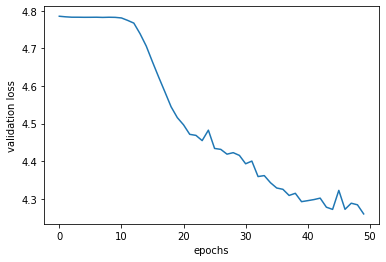

In [23]:
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

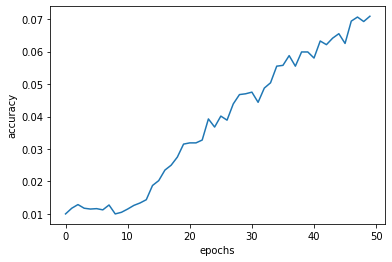

In [24]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

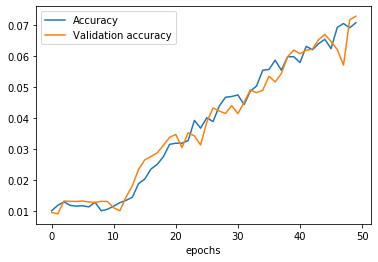

In [25]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

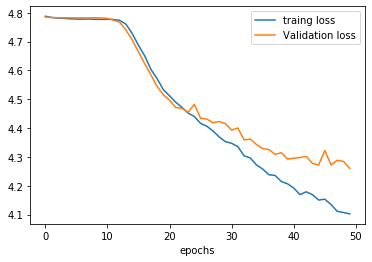

In [26]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

## 6. Model z porzucaniem (Dropout)
Metoda porzucania (dropout) to najpopularniejszy sposób do walki z przetrenowaniem w przypadku sieci neuronowych. Dropout polega na losowym ustawieniu wychodzących krawędzi ukrytych jednostek (neuronów tworzących ukryte warstwy) na 0 przy każdej aktualizacji fazy treningu.

Metoda ta jest bardzo efektywna, ponieważ co każde przejście losowo wyłączane są połączenia. Dzięki temu sieć neuronowa nie nauczy się „na pamięć” zbyt szybko, ponieważ architektura co przeliczenie odrobinę się zmienia poprzez zerowanie losowych połączeń neuronów.

W Tensorflow dodajemy kolejne warstwy wykorzystując „Dropout” oraz definiując jaka część neuronów ma zostać zapomniana. Np. dla wartości 0.2 zostanie wylosowanych 20% połączeń do wyzerowania.

In [27]:
clfd = Sequential()
clfd.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))   
clfd.add(MaxPooling2D(pool_size=(2,2)))  
clfd.add(Dropout(0.5))

clfd.add(Conv2D(32,(3,3), activation='relu'))
clfd.add(MaxPooling2D(pool_size=(2,2)))
clfd.add(Dropout(0.25))

clfd.add(Conv2D(64, (3, 3), activation='relu'))
clfd.add(MaxPooling2D(pool_size=(2, 2)))
clfd.add(Dropout(0.10))
#Flattening
clfd.add(Flatten())
        
#Adding An ANN
#lets take 128 hidden nodes in hidden layer - tutaj zwiększamy z 64 na 128. 
clfd.add(Dense(units=128,activation='relu'))
#clf.add(Dense(units=64, activation='relu'))
clfd.add(Dropout(0.5))
clfd.add(Dense(units=120,activation='softmax'))
#stochastic gradient descent -Adam -optimizer
#loss func categorical cross entropy
#metrics = accuracy
clfd.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
hist=clfd.fit_generator(
        training_set,
        steps_per_epoch=400,
        epochs=50,
        validation_data=test_set,
        validation_steps=2222,
        callbacks=[early_stopping_monitor])

Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 4.7927 - accuracy: 0.0108

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
test_set = np.array(test_set, np.float32)/255.0
predictions = clfd.predict(test_set)
predictions[0].shape
predictions_df = pd.DataFrame(predictions)

In [ ]:
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
#predictions_df.index = test_set_ids
predictions_df

In [ ]:
predictions_df.to_csv('interim_submission_dropout.csv',sep=",")

In [ ]:
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

In [ ]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

In [ ]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

## Podsumowanie


Tak jak zostało to opisane we wprowadzeniu na podstawie zdjęć psów, z wykorzystaiem uczenia sieci neuronowej przypisaliśmy ich rasy. Proces uczenia sieci wykonaliśmy poprzez Konwulacyjną (Splotową) sieć neuronową ze względu na jej efektywniejsze działanie nie wykorzystujące dużej ilości parametrów.
Podzieliliśmy zbiory na testowy ( w tym treningowy)  i walidacyjny, następnie załadowaliśmy odpowiednią proporcjonalną ilość zdjęć.Następnie dokonaliśmy prob uczących przez sieć z wykorzystaniem biblioteki KERAS.
Proces wyglądał następująco:

- Na wejściu algorytm otrzymuje zbiór zawierający N obrazów, każdy z nich przypisany jest do jednej z K klas. 
- Następnie wykorzystuje się zbiór treningowy do szkolenia klasyfikatora tak, aby był on w stanie jak najepiej przyporządkować etykietę do zdjęcia.
- Na koniec ocenia się jakość klasyfikatora, prosząc go o przewidywanie etykiet dla nowego zestawu obrazów, których nigdy wcześniej nie widział, po czym porównamy prawdziwe etykiety tych obrazów z przewidywanymi przez klasyfikator.

Po przetworzeniu procesów otrzymaliśmy wyniki :
Na zbiorze walidacyjnym wraz ze wzrostem liczby przetworzonych zdjęć rośnie precyzja przypisywania nazwy rasy do danego zdjęcia. 


## Bibliografia
- http://home.agh.edu.pl/~horzyk/lectures/ai/SztucznaInteligencja-UczenieG%C5%82%C4%99bokichSieciNeuronowych.pdf
- https://keras.io/api/
- https://miroslawmamczur.pl/przykladowa-siec-neuronowa-mlp-w-tensorflow/